# This is used for a test

In [146]:
import cv2, simplejson, os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

In [147]:
fileName = '20170507T155114.708081'
fileNameVideo = fileName + '.avi'
vidcap = cv2.VideoCapture(fileNameVideo)

In [148]:
fileNameEvents = fileName + '-events.json'
events = simplejson.loads(open(fileNameEvents).read())
events

[{'end-frame': 111,
  'event-class': '0 added',
  'object-class': 'Clover Organic 2% Milk',
  'start-frame': 81},
 {'end-frame': 135,
  'event-class': '1 removed',
  'object-class': 'Clover Organic 2% Milk',
  'start-frame': 111},
 {'end-frame': 176,
  'event-class': '0 added',
  'object-class': 'Horizon Organic Chocolate Milk',
  'start-frame': 141},
 {'end-frame': 196,
  'event-class': '1 removed',
  'object-class': 'Horizon Organic Chocolate Milk',
  'start-frame': 176},
 {'end-frame': 228,
  'event-class': '0 added',
  'object-class': 'Horizon Organic Chocolate Milk',
  'start-frame': 208},
 {'end-frame': 264,
  'event-class': '1 removed',
  'object-class': 'Horizon Organic Chocolate Milk',
  'start-frame': 234}]

In [149]:
dataDict = {}
dataDict['data'] = []
dataDict['label'] = []
frames_start = np.zeros(len(events))
frames_end = np.zeros(len(events))
labels = np.zeros(len(events))
for idx, event in enumerate(events):
    frames_start[idx] = event['start-frame']
    frames_end[idx] = event['end-frame']-1
    if event['event-class'] == '0 added' or event['event-class'] == '0 removed':
        labels[idx] = 0
    elif event['event-class'] == '1 added':
        labels[idx] = 1
    elif event['event-class'] == '1 removed':
        labels[idx] = 3
    elif event['event-class'] == '2 added':
        labels[idx] = 2
    dataDict['label'].append(labels[idx])
print(frames_start)
print(frames_end)
print(labels)
print (dataDict['label'])

[  81.  111.  141.  176.  208.  234.]
[ 110.  134.  175.  195.  227.  263.]
[ 0.  3.  0.  3.  0.  3.]
[0.0, 3.0, 0.0, 3.0, 0.0, 3.0]


In [150]:
n = 5
frames = np.zeros((n,frames_start.shape[0]))
for i in range(frames_start.shape[0]):
    frames[:,i] = np.linspace(frames_start[i],frames_end[i],n)
frames = np.floor(frames)

In [151]:
inputSize = 64
dirname = 'img'
data_len = frames_start.shape[0]
vidcap = cv2.VideoCapture(fileNameVideo)
if not os.path.isdir(dirname):
    os.mkdir(dirname)

for i in range(data_len):
    vidcap = cv2.VideoCapture(fileNameVideo)
    success,image = vidcap.read()
    count = 0
    success = True
    one_data = []
    while success:
        success,image = vidcap.read()
        #print('Read a new frame: '), success
        if np.any(frames[:,i] == count):
            image_crop = image[100:500, 150:800]
            image_down = cv2.resize(image_crop, dsize=(inputSize,inputSize), interpolation = cv2.INTER_CUBIC)
            imageFileName = '%s/f%d.jpg' % (dirname, count)
            cv2.imwrite(imageFileName, image_down)     # save frame as JPEG file
            one_data.append(image_down)
        count += 1
    dataDict['data'].append(one_data)
    vidcap.release()


In [152]:
print (np.array(dataDict['label']).shape)
print (np.array(dataDict['data']).shape)

(6,)
(6, 5, 64, 64, 3)


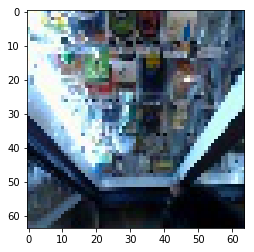

In [153]:
f = img.imread('img/f%d.jpg' % np.random.choice(frames.reshape(frames.size)))
plt.imshow(f)
plt.show()

# Real data preprocessing starts from here

In [154]:
count = 0
dataDict = {}
dataDict['data'] = []
dataDict['label'] = []

for filename in os.listdir('.'):
    
    if filename.endswith('.avi'): 
        fileName = os.path.splitext(filename)[0]
        
        # read json
        fileNameEvents = fileName + '-events.json'
        events = simplejson.loads(open(fileNameEvents).read())
        
        # store start/end frames and labels
        frames_start = np.zeros(len(events))
        frames_end = np.zeros(len(events))
        labels = np.zeros(len(events))
        for idx, event in enumerate(events):
            frames_start[idx] = event['start-frame']
            frames_end[idx] = event['end-frame']-1
            if event['event-class'] == '0 added' or event['event-class'] == '0 removed':
                labels[idx] = 0
            elif event['event-class'] == '1 added':
                labels[idx] = 1
            elif event['event-class'] == '1 removed':
                labels[idx] = 3 # used to be -1
            elif event['event-class'] == '2 added':
                labels[idx] = 2
            dataDict['label'].append(labels[idx])
        
        # sample frame indices
        n = 5
        frames = np.zeros((n,frames_start.shape[0]))
        for i in range(frames_start.shape[0]):
            frames[:,i] = np.linspace(frames_start[i],frames_end[i],n)
        frames = np.floor(frames)

        # make a separate image folder
        if not os.path.isdir('img'):
            os.mkdir('img')
        temp = 'img/%s' % fileName
        if not os.path.isdir(temp):
            os.mkdir(temp)
            
        for i in range(frames_start.shape[0]):
            # load video
            fileNameVideo = fileName + '.avi'
            vidcap = cv2.VideoCapture(fileNameVideo)

            # data augmentation
            inputSize = 64
            success,image = vidcap.read()
            count = 0
            success = True
            one_data = []
            while success:
                success,image = vidcap.read()
                if np.any(frames[:,i] == count):
                    # center crop
                    image_crop = image[100:500, 150:800]

                    # downsampling
                    image_down = cv2.resize(image_crop, dsize=(inputSize,inputSize), interpolation = cv2.INTER_CUBIC)
                    one_data.append(image_down)
                    # write image
                    imageFileName = 'img/%s/f%d.jpg' % (fileName, count)
                    cv2.imwrite(imageFileName, image_down)     # save frame as JPEG file
                count += 1
                
            dataDict['data'].append(one_data)
            vidcap.release()
        
    else:
        continue

In [155]:
print (np.array(dataDict['label']).shape)
print (np.array(dataDict['data']).shape)

(101,)
(101, 5, 64, 64, 3)


# save result

In [165]:
import json
# each separate dict()
with open('label.json', 'w') as fp:
    json.dump(np.array(dataDict['label']).tolist(), fp, indent=4)
with open('data.json', 'w') as fp:
    json.dump(np.array(dataDict['data']).tolist(), fp, indent=4)

# load result

In [166]:
with open('label.json', 'r') as fp:
    label_load = json.load(fp)
with open('data.json', 'r') as fp:
    data_load = json.load(fp)